In [36]:
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf
pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [4]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2020-01-01"

In [44]:
class StrategyTester():
    def __init__(self, symbol, sma_short, sma_long, start, end, rawdata):
        self.end = end
        self.start = start
        self.sma_long = sma_long
        self.sma_short = sma_short
        self.symbol = symbol
        self.rawdata = rawdata
        self.data = None ##
        self.results = None
        self.perf = None
        self.outperf = None
        
    def run(self):
        self.data = self.get_data()
        self.results = self.get_results()
        self.perf = self.results['cstrategy'].iloc[-1]
        self.outperf = self.perf - self.results['creturns'].iloc[-1] 

    def get_data(self):
        df = self.rawdata
        df['returns'] = np.log(df['price'] / df['price'].shift(1))
        df['sma_short'] = df['price'].rolling(self.sma_short).mean()
        df['sma_long'] = df['price'].rolling(self.sma_long).mean()
        return df
    
    def get_results(self):
        data = self.data.copy().dropna()
        data['position'] = np.where(data['sma_short'] > data['sma_long'], 1, -1)
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace=True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp) 
        return data
    
    def plot_results(self):
        title = "{} | SMA short = {} | SMA long = {}".format(self.symbol, self.sma_short, self.sma_long)
        self.results[['creturns', 'cstrategy']].plot(title= title, figsize=(20, 10))


In [38]:
tester = StrategyTester(symbol, 50, 200, start, end)

In [39]:
tester.data

[*********************100%%**********************]  1 of 1 completed


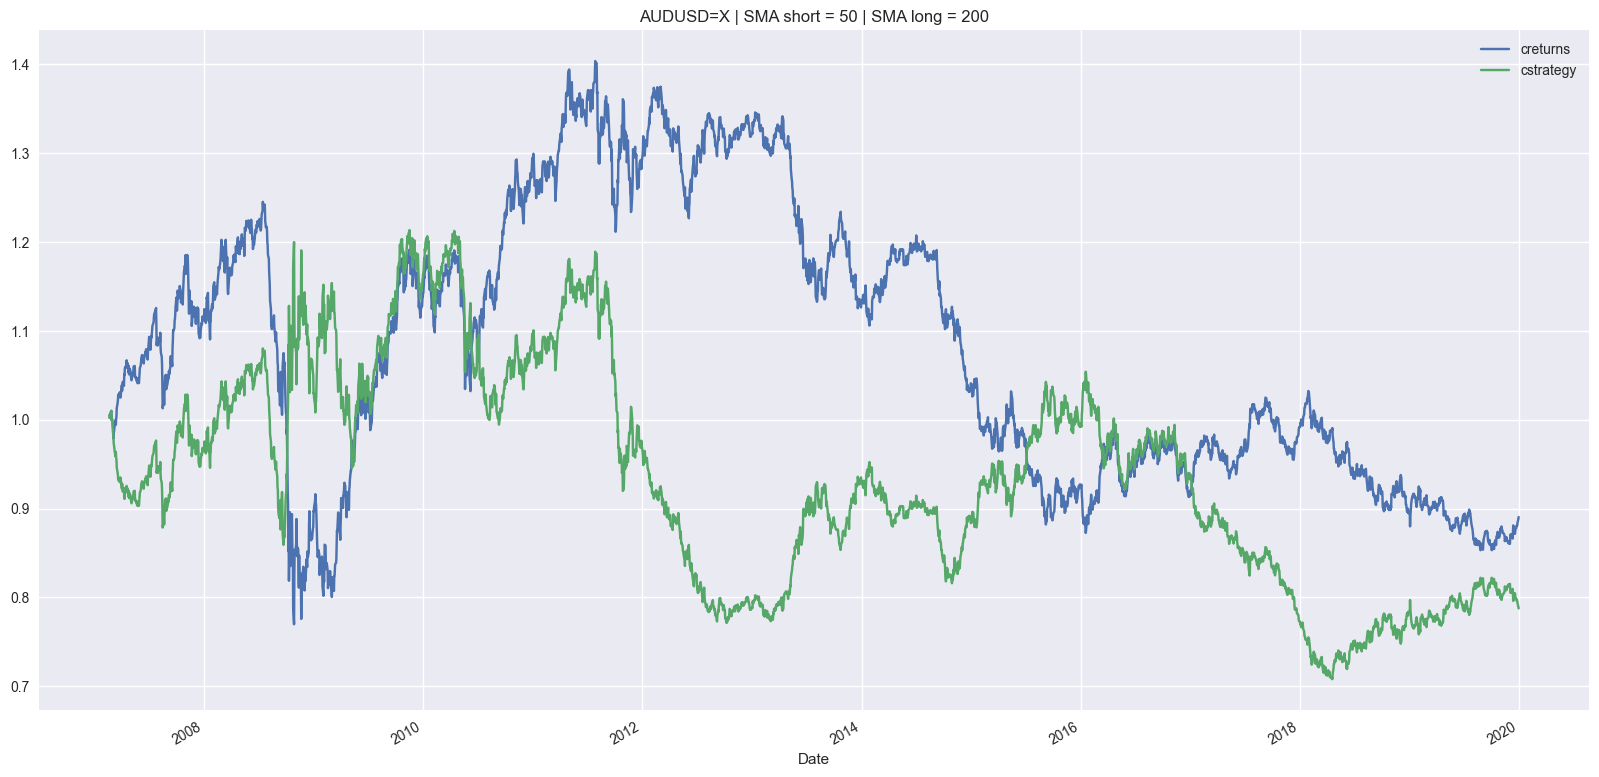

In [41]:
aud = StrategyTester("AUDUSD=X", 50, 200, '2004-01-01', '2020-01-01')
aud.run()

aud.plot_results()

In [50]:

def best_sma_for_instrument(instrument, start, end):
    df = yf.download(instrument, start, end).Close.to_frame()
    df.rename(columns={"Close": "price"}, inplace=True)
    
    sma_s_range = range(10,80,1)
    sma_l_range = range(100,252,1)
    combinations = list(product(sma_s_range, sma_l_range))
    resultsDf = pd.DataFrame(columns=['sma_s', 'sma_l', 'strategy'])
    
    for combination in combinations:
        s = StrategyTester(instrument,combination[0], combination[1], start,end, df)
        s.run()
        resultDict = {'sma_s': combination[0], 'sma_l': combination[1], 'strategy': s.outperf}
        print("{}/{} result is {}".format(combination[0], combination[1], s.outperf))
        resultsDf.loc[len(resultsDf)] = resultDict
    
    return resultsDf

instrument = 'AUDUSD=X'
start = '2004-01-01'
end = '2024-08-14'

results = best_sma_for_instrument(instrument, start, end)
        

[*********************100%%**********************]  1 of 1 completed


10/100 result is 0.12963430173920332
10/101 result is 0.16378693830564162
10/102 result is 0.2485946706912765
10/103 result is 0.1622845135067189
10/104 result is 0.11656203037238733
10/105 result is 0.16877350733295904
10/106 result is 0.1443999970392239
10/107 result is 0.12980417085880103
10/108 result is 0.20371282470632135
10/109 result is 0.19451024707724285
10/110 result is 0.2735404121467945
10/111 result is 0.2648062221874832
10/112 result is 0.2519287391686701
10/113 result is 0.25525733899943703
10/114 result is 0.31821675521785675
10/115 result is 0.3376772847526206
10/116 result is 0.3795091715807667
10/117 result is 0.3213510873403457
10/118 result is 0.16801174526447438
10/119 result is 0.15758651064016604
10/120 result is 0.16499673694275752
10/121 result is 0.15432193661946858
10/122 result is 0.09237133293239408
10/123 result is 0.07103453751024602
10/124 result is 0.07080669213668123
10/125 result is 0.1139787280345459
10/126 result is 0.14915774768243228
10/127 resu

In [51]:
results

,sma_s,sma_l,strategy
0,10,100,0.1296
1,10,101,0.1638
2,10,102,0.2486
3,10,103,0.1623
4,10,104,0.1166
...,...,...,...
10635,79,247,0.1423
10636,79,248,0.1311
10637,79,249,0.1494
10638,79,250,0.1324


[*********************100%%**********************]  1 of 1 completed


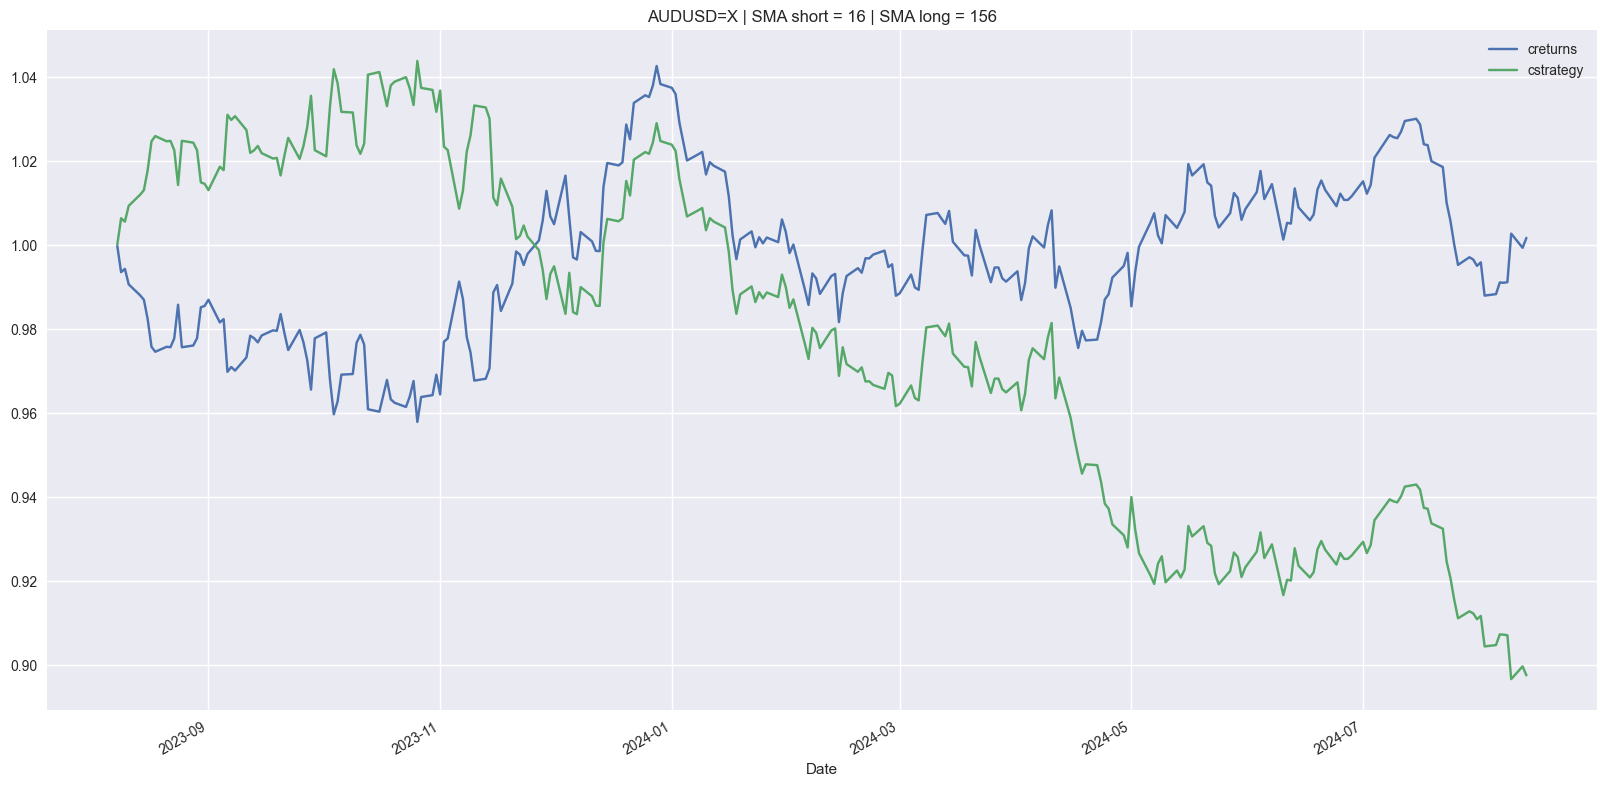

In [57]:
instrument = 'AUDUSD=X'
start = '2023-01-01'
end = '2024-08-14'
df = yf.download(instrument, start, end).Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)


audbest = StrategyTester(instrument, 16, 156, start, end, df)
audbest.run()
audbest.plot_results()